## 最終課題(irisデータのニューラルネットワーク構築)

In [11]:
# 必要なライブラリのインポート
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

from common import functions
from common import optimizer
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# データセットのロード
# iris.data = [(がく片の長さ , がく片の幅 , 花びらの長さ , 花びらの幅)]
iris = datasets.load_iris()

x_vals = np.array([x[0:3] for x in iris.data])
y_vals = np.array([x[3] for x in iris.data])

# トレーニングデータ（80％）とテストデータ（20％）に分割
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.2, shuffle=True)

In [12]:
class LayerNet:
    
    # コンストラクタ
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
    
    # ネットワークの初期化を実施
    def init_network(self):
        network = {}
    
        # 重みの設定
        # 通常設定
        network['W1'] = weight_init * np.random.randn(self.input_size, self.hidden_size1)
        network['W2'] = weight_init * np.random.randn(self.hidden_size1, self.hidden_size2)
        network['W3'] = weight_init * np.random.randn(self.hidden_size2, self.output_size)

#         # Xavierでの設定
#         network['W1'] = np.random.randn(input_layer_size, hidden_layer_size1) / (np.sqrt(input_layer_size))
#         network['W2'] = np.random.randn(hidden_layer_size1, hidden_layer_size2) / (np.sqrt(hidden_layer_size1))
#         network['W3'] = np.random.randn(hidden_layer_size2, output_layer_size) / (np.sqrt(hidden_layer_size2))

#         # Heでの設定
#         network['W1'] = np.random.randn(input_layer_size, hidden_layer_size1) / (np.sqrt(input_layer_size)) * np.sqrt(2)
#         network['W2'] = np.random.randn(hidden_layer_size1, hidden_layer_size2) / (np.sqrt(hidden_layer_size1)) * np.sqrt(2)
#         network['W3'] = np.random.randn(hidden_layer_size2, output_layer_size) / (np.sqrt(hidden_layer_size2)) * np.sqrt(2)

        # バイアスの設定
        network['b1'] = np.zeros(self.hidden_size1)
        network['b2'] = np.zeros(self.hidden_size2)
        network['b3'] = np.zeros(self.output_size)

        return network
    

Generation: 10. 誤差 = 11.450121112315465
Generation_Test: 10. 誤差(テスト) = 15.884241831316853
Generation: 20. 誤差 = 12.634894000069806
Generation_Test: 20. 誤差(テスト) = 14.131768618535567
Generation: 30. 誤差 = 11.453786235701692
Generation_Test: 30. 誤差(テスト) = 9.816429718451603
Generation: 40. 誤差 = 10.418315299102847
Generation_Test: 40. 誤差(テスト) = 6.372246353435363
Generation: 50. 誤差 = 11.03149837668355
Generation_Test: 50. 誤差(テスト) = 11.934726191894969
Generation: 60. 誤差 = 8.643779307730957
Generation_Test: 60. 誤差(テスト) = 9.774656735372453
Generation: 70. 誤差 = 9.487545661551485
Generation_Test: 70. 誤差(テスト) = 8.671321981590486
Generation: 80. 誤差 = 8.862570946350706
Generation_Test: 80. 誤差(テスト) = 8.949977299864464
Generation: 90. 誤差 = 8.953983720615245
Generation_Test: 90. 誤差(テスト) = 7.080826426478
Generation: 100. 誤差 = 9.936203844371754
Generation_Test: 100. 誤差(テスト) = 8.74318494512317
Generation: 110. 誤差 = 12.80426770584342
Generation_Test: 110. 誤差(テスト) = 10.24216245051299
Generation: 120. 誤差 = 9.3

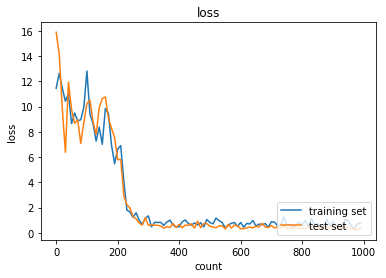

In [13]:
# 学習率
learning_rate = 0.001

# 重み補正係数
weight_init = 0.01

# 入力層
input_layer_size = 3

# 中間層
hidden_layer_size1 = 50
hidden_layer_size2 = 20

# 出力層
output_layer_size = 1

# 学習回数(1万回)
learning_num = 1000

# 描写頻度
plot_interval=10

# ミニバッチサイズ
batch_size = 30

# 訓練用サイズ
train_size = len(x_train)
# テスト用サイズ
test_size = len(x_test)

layerNet = LayerNet(input_layer_size, hidden_layer_size1, hidden_layer_size2, output_layer_size)
    
# 順伝播
def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    # 勾配
    u1 = np.dot(x, W1) + b1
    # 活性化関数 Relu関数を使用
    z1 = functions.relu(u1)
    # 勾配
    u2 = np.dot(z1, W2) + b2
    # 活性化関数 Relu関数を使用
    z2 = functions.relu(u2)
    # 勾配
    u3 = np.dot(z2, W3) + b3
    # 誤差関数(恒等写像)
    y = u3
    
    return z1, z2, y

# 逆伝播
def backward(x, d, z1, z2, y):
    grad = {}
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    # 出力層でのデルタ 
    delta3 = functions.d_least_square(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 活性化関数の導関数 Relu関数
    delta2 = np.dot(delta3, W3.T) * functions.d_relu(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 活性化関数の導関数 Relu関数
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)
    
    return grad

# パラメータの初期化
network = layerNet.init_network()

losses = []
losses_test = []

for i in range(learning_num):
    # Todo:訓練用とテスト用でコードが冗長なので修正
    # 訓練用の学習
    # ------------ここから------------
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練ラベルデータを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    y_batch = y_train[batch_mask]
    y_batch = y_batch[:, np.newaxis]

    z1, z2, y = forward(network, x_batch)
    grad = backward(x_batch, y_batch, z1, z2, y)

    # optimizerの設定 モメンタムを利用
    opt = optimizer.Momentum(learning_rate)
    opt.update(network, grad)
    # ------------ここまで------------

    # テスト用の学習
    # ------------ここから------------
    batch_mask_t = np.random.choice(test_size, batch_size)
    # ミニバッチに対応する教師訓練データを取得    
    x_test_batch = x_test[batch_mask_t]
    # ミニバッチに対応する訓練正解データを取得する
    y_test_batch = y_test[batch_mask_t]
    y_test_batch = y_test_batch[:, np.newaxis]
    z1_t, z2_t, y_t = forward(network, x_test_batch) 

    test_grad = backward(x_test_batch, y_test_batch, z1_t, z2_t, y_t)

    # optimizerの設定　モメンタムを利用
    opt = optimizer.Momentum(learning_rate)
    opt.update(network, test_grad)
    # ------------ここまで------------
    
    if (i + 1) % plot_interval == 0:
        loss = functions.least_square(y_batch, y)
        losses.append(loss)
        print('Generation: ' + str(i+1) + '. 誤差 = ' + str(loss))
        loss_test = functions.least_square(y_test_batch, y_t)
        losses_test.append(loss_test)
        print('Generation_Test: ' + str(i+1) + '. 誤差(テスト) = ' + str(loss_test))

lists = range(0, learning_num, plot_interval)
plt.plot(lists, losses, label="training set")
plt.plot(lists, losses_test, label="test set")
plt.legend(loc="lower right")
plt.title("loss")
plt.xlabel("count")
plt.ylabel("loss")
# グラフの表示
plt.show()